In [1]:
import sys

sys.path.append("..")

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchtext.vocab import Vectors, build_vocab_from_iterator

from utils.dataset import TabularDataset
from utils.tokenizer import MeCabTokenizer

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_dataset = TabularDataset("../data/train.tsv")
test_dataset = TabularDataset("../data/test.tsv")

In [4]:
tokenizer = MeCabTokenizer()

In [5]:
vocab = build_vocab_from_iterator(
    [tokenizer.tokenize(text) for text in train_dataset.texts],
    min_freq=10,
    specials=["<unk>", "<pad>"],
)
vocab.set_default_index(vocab["<unk>"])

In [6]:
def collate_batch(batch):
    text_list = [torch.tensor(vocab(tokenizer.tokenize(text))) for text, _ in batch]
    label_list = [0 if label != 3 else 1 for _, label in batch]
    text_list = pad_sequence(text_list, padding_value=vocab["<pad>"])
    label_list = torch.tensor(label_list, dtype=torch.float)
    return text_list.to(device), label_list.to(device)

In [7]:
batch_size = 64

weights = [1 / (train_dataset.labels == label).sum() for label in train_dataset.labels]
sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights))

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, sampler=sampler, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch
)

In [8]:
class LSTM(nn.Module):
    def __init__(self, vectors):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(vectors)
        self.lstm = nn.LSTM(200, 64, num_layers=2, bidirectional=True)
        self.linear = nn.Linear(64 * 2, 1)

    def forward(self, text):
        output = self.embedding(text)
        output, (hn, cn) = self.lstm(output)
        output = torch.cat([hn[-2], hn[-1]], dim=1)
        output = self.linear(output)
        output = torch.sigmoid(output)
        return output.squeeze()

In [9]:
japanese_word2vec_vectors = Vectors(name="../data/japanese_word2vec_vectors.vec")
vectors = japanese_word2vec_vectors.get_vecs_by_tokens(vocab.get_itos())

model = LSTM(vectors).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

In [10]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for text, label in dataloader:
        output = model(text)

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = output.round().int()
        acc = (pred == label).sum() / len(pred)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [11]:
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer)
    print(f"Epoch {epoch + 1}/{num_epochs}", end=" ")
    print(f"| train | Loss: {train_loss:.4f} Accuracy: {train_acc:.4f}")
    if train_acc > 0.8:
        break

Epoch 1/10 | train | Loss: 0.6113 Accuracy: 0.7242
Epoch 2/10 | train | Loss: 0.5660 Accuracy: 0.7465
Epoch 3/10 | train | Loss: 0.5494 Accuracy: 0.7511
Epoch 4/10 | train | Loss: 0.5232 Accuracy: 0.7470
Epoch 5/10 | train | Loss: 0.4697 Accuracy: 0.7626
Epoch 6/10 | train | Loss: 0.4139 Accuracy: 0.7939
Epoch 7/10 | train | Loss: 0.3801 Accuracy: 0.8197


In [12]:
model.eval()
y_true = []
y_pred = []
y_score = []

with torch.no_grad():
    for text, label in test_dataloader:
        output = model(text)
        y_true += label.tolist()
        y_pred += output.round().int().tolist()
        y_score += output.tolist()

In [13]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97      8536
         1.0       0.04      0.20      0.07       104

    accuracy                           0.93      8640
   macro avg       0.52      0.57      0.52      8640
weighted avg       0.98      0.93      0.95      8640



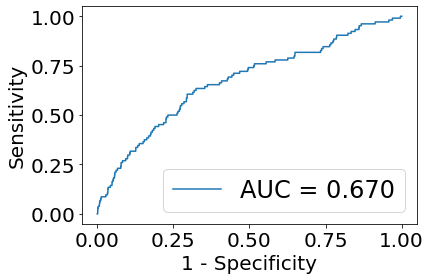

In [14]:
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)

plt.rcParams["font.size"] = 20
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.legend(loc="lower right", fontsize=24)
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
# plt.savefig("../roc_curve.pdf", bbox_inches="tight")
plt.show()

In [15]:
pd.set_option("display.max_rows", None)

df = pd.read_csv("../data/test.tsv", sep="\t")
df["Label"] = df["Label"].map(lambda label: 0 if label != 3 else 1)
df["Predicted"] = y_pred
df.query("Label == Predicted == 1")

,Sentence,Writer_Joy,Reader1_Joy,Reader2_Joy,Reader3_Joy,Readers_mean,Readers_std,Difference,Label,Predicted
4,THE W 今年が1番のめり込んで見たかもみんな頑張れ！みんな売れろ！って思っちゃう,1,3,3,2,2.666667,0.57735,-1.666667,1,1
262,初めての都内運転でしたが実家から貰ったお守りと雛ちゃんのおかげで無事終わりました♪,0,1,1,2,1.333333,0.57735,-1.333333,1,1
505,クリスのドラム配置好き,0,1,1,2,1.333333,0.57735,-1.333333,1,1
1465,星野源さんの「Soul」という曲、歌うと実に気持ちが良い。BPMとかよく知らんけど聞いていて...,1,3,2,2,2.333333,0.57735,-1.333333,1,1
1639,YMOにハマりたての頃は、その音楽の素晴らしさに感銘受け過ぎて、細野さんの画像ばかり集めてか...,1,3,2,3,2.666667,0.57735,-1.666667,1,1
1820,今日は約10時間くらい本を書いてました！疲れたけど、モノ作り楽しいです(≧∇≦)/読者の方々...,1,2,3,2,2.333333,0.57735,-1.333333,1,1
2016,基本的に女の子っぽい女の子が好きなんよなぁ。アンジュよりとこちゃんどんどん好きになる,0,3,2,2,2.333333,0.57735,-2.333333,1,1
2465,プロフェッショナルももち好き,0,1,1,2,1.333333,0.57735,-1.333333,1,1
2956,人に優しくすると気持ちが良い！,1,2,2,3,2.333333,0.57735,-1.333333,1,1
3093,今日はたくさんおたくトークできたし、いっぱい働いて充実した日だったなぁ,1,2,3,2,2.333333,0.57735,-1.333333,1,1
